# GridSearch para clasificación de ratings

**Clasificadores a considerar**:
- linearSVC
- KNeighbors
- RandomForest
- MLP (red neuronal)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import classification_report
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
import re

In [2]:
df_train = pd.read_pickle('train.pickle')

## DF con BERT integrado

In [3]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np

MODEL = "distilbert-videogame-descriptions-rating"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def sentence_clf_output(text):
    """retorna el SequenceClassifierOutput"""
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input, return_dict=True, output_hidden_states=True)
    return output

def logits_embedding(clf_output):
    # retorna el vector de scores de clasificacion (antes de la capa softmax)
    return clf_output['logits'][0].detach().numpy().reshape(1,5)

In [4]:
def integrar_bert_logits(df_in):
    df = df_in.copy(deep=True)

    embed = lambda row: logits_embedding(sentence_clf_output(row))
    bert_logits = np.concatenate(df['short_description'].apply(embed).to_numpy())  # .reshape(100,3)

    df[['bert1','bert2','bert3','bert4','bert5']] = pd.DataFrame(bert_logits, index= df.index)

    return df

In [5]:
%%time
df_train = integrar_bert_logits(df_train)

CPU times: user 36min 33s, sys: 13.4 s, total: 36min 46s
Wall time: 4min 35s


## Pre-procesamiento

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class Nothing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return X


class CategoriesTokenizer:
    def __init__(self):
        pass

    def __call__(self, doc):
        return doc.split(';')

boc_some_values = CountVectorizer(
    tokenizer = CategoriesTokenizer(),
    max_df = 1.0,
    min_df = 0.05  # hiperparametro a optimizar
    # valores para GridSearch : [5%, 10%, 15%] ???
    )


boc_many_values = CountVectorizer(
    tokenizer = CategoriesTokenizer(),
    max_df = 1.0,
    min_df = 1  # hiperparametro a optimizar
    # valores para GridSearch : [5, 10, 15] ???
    )

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize 

stop_words = stopwords.words('english')

# Definimos un tokenizador con Stemming
class StemmerTokenizer:
    def __init__(self):
        self.ps = PorterStemmer()
    def __call__(self, doc):
        doc_tok = word_tokenize(doc)
        doc_tok = [t for t in doc_tok if t not in stop_words]
        return [self.ps.stem(t) for t in doc_tok]

bow = CountVectorizer(
    tokenizer= StemmerTokenizer(),
    ngram_range=(1,2),
    min_df = 0.05, max_df = 0.85
    )

def custom_features(dataframe_in):
    df = dataframe_in.copy(deep=True)

    df['month'] = pd.to_datetime(df['release_date']).dt.month
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.to_julian_date())

    df['revenue'] = pd.Series([0 for _ in range(len(dataframe_in))])

    df.loc[df.publisher.str.match('.*microsoft.*', flags=re.IGNORECASE).values, 'revenue'] = 10.260
    df.loc[df.publisher.str.match('.*netease.*', flags=re.IGNORECASE).values, 'revenue'] = 6.668
    df.loc[df.publisher.str.match('.*activision.*', flags=re.IGNORECASE).values, 'revenue'] = 6.388
    df.loc[df.publisher.str.match('.*electronic.*', flags=re.IGNORECASE).values, 'revenue'] = 5.537
    df.loc[df.publisher.str.match('.*bandai.*', flags=re.IGNORECASE).values, 'revenue'] = 3.018
    df.loc[df.publisher.str.match('.*square.*', flags=re.IGNORECASE).values, 'revenue'] = 2.386
    df.loc[df.publisher.str.match('.*nexon.*', flags=re.IGNORECASE).values, 'revenue'] = 2.286
    df.loc[df.publisher.str.match('.*ubisoft.*', flags=re.IGNORECASE).values, 'revenue'] = 1.446
    df.loc[df.publisher.str.match('.*konami.*', flags=re.IGNORECASE).values, 'revenue'] = 1.303
    df.loc[df.publisher.str.match('.*SEGA.*').values, 'revenue'] = 1.153
    df.loc[df.publisher.str.match('.*capcom.*', flags=re.IGNORECASE).values, 'revenue'] = 0.7673
    df.loc[df.publisher.str.match('.*warner.*', flags=re.IGNORECASE).values, 'revenue'] = 0.7324

    return df


preprocessing_bert = ColumnTransformer(
    transformers=[
        ('BoC-plat',boc_some_values,'platforms'),
        ('BoC-cat',boc_some_values,'categories'),
        ('BoC-genres',boc_some_values,'genres'),
        ('BoC-tags',boc_some_values,'tags'),

        ('BoC-dev',boc_many_values,'developer'),
        ('BoC-pub',boc_many_values,'publisher'),

        ('OneHotEncoder',OneHotEncoder(handle_unknown='ignore'),['month']),
        ('MinMaxScaler',MinMaxScaler(),['required_age','price','release_date']),
        ('BoxCox',PowerTransformer(method='yeo-johnson'),['achievements','average_playtime','revenue']),
        ('unchanged',Nothing(),['english','bert1','bert2','bert3','bert4','bert5'])
])

preprocessing_bow = ColumnTransformer(
    transformers=[
        ('BoC-plat',boc_some_values,'platforms'),
        ('BoC-cat',boc_some_values,'categories'),
        ('BoC-genres',boc_some_values,'genres'),
        ('BoC-tags',boc_some_values,'tags'),

        ('BoC-dev',boc_many_values,'developer'),
        ('BoC-pub',boc_many_values,'publisher'),

        ('OneHotEncoder',OneHotEncoder(handle_unknown='ignore'),['month']),
        ('MinMaxScaler',MinMaxScaler(),['required_age','price','release_date']),
        ('BoxCox',PowerTransformer(method='yeo-johnson'),['achievements','average_playtime','revenue']),
        ('unchanged',Nothing(),['english']),
        ('BoWText',bow,'short_description')
])

preprocessing_bert_bow = ColumnTransformer(
    transformers=[
        ('BoC-plat',boc_some_values,'platforms'),
        ('BoC-cat',boc_some_values,'categories'),
        ('BoC-genres',boc_some_values,'genres'),
        ('BoC-tags',boc_some_values,'tags'),

        ('BoC-dev',boc_many_values,'developer'),
        ('BoC-pub',boc_many_values,'publisher'),

        ('OneHotEncoder',OneHotEncoder(handle_unknown='ignore'),['month']),
        ('MinMaxScaler',MinMaxScaler(),['required_age','price','release_date']),
        ('BoxCox',PowerTransformer(method='yeo-johnson'),['achievements','average_playtime','revenue']),
        ('unchanged',Nothing(),['english','bert1','bert2','bert3','bert4','bert5']),
        ('BoWText',bow,'short_description')
])

preprocessing = ColumnTransformer(
    transformers=[
        ('BoC-plat',boc_some_values,'platforms'),
        ('BoC-cat',boc_some_values,'categories'),
        ('BoC-genres',boc_some_values,'genres'),
        ('BoC-tags',boc_some_values,'tags'),

        ('BoC-dev',boc_many_values,'developer'),
        ('BoC-pub',boc_many_values,'publisher'),

        ('OneHotEncoder',OneHotEncoder(handle_unknown='ignore'),['month']),
        ('MinMaxScaler',MinMaxScaler(),['required_age','price','release_date']),
        ('BoxCox',PowerTransformer(method='yeo-johnson'),['achievements','average_playtime','revenue']),
        ('unchanged',Nothing(),['english']),
])

In [7]:
df_train = custom_features(df_train)
X_train, X_eval, y_train, y_eval = train_test_split(df_train, df_train['rating'], test_size=0.3, random_state=0, stratify=df_train['rating'])

## Ahora si el gridsearch

In [8]:
from sklearn.svm import LinearSVC


pipeline = Pipeline(
    [("procesamiento", preprocessing),
    ("selector", SelectPercentile(f_classif, percentile=90)),
    ("classifier", LinearSVC(random_state=0))]
)

## SVC Lineal

In [10]:
grilla_SV = {
    "classifier": [LinearSVC(random_state=0)],
    "classifier__C":[0.01, 1., 100., 1000.],
    "selector__percentile": [25, 50, 75, 95, 100],
    "selector__score_func":[f_classif],
    "procesamiento" : [preprocessing, preprocessing_bert, preprocessing_bert_bow, preprocessing_bow],
    "procesamiento__BoC-cat__min_df" : [0.05],
    "procesamiento__BoC-genres__min_df" : [0.05],
    "procesamiento__BoC-tags__min_df" : [0.05],
    "procesamiento__BoC-dev__min_df" : [2],
    "procesamiento__BoC-pub__min_df" : [2],
}

gs_SV = HalvingGridSearchCV(
    pipeline,
    grilla_SV,
    scoring = 'f1_weighted',
    n_jobs=-1,
    verbose = 0,
    random_state = 0,
    error_score = 0
)

In [12]:
gs_SV.fit(X_train, y_train)

/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/

HalvingGridSearchCV(error_score=0,
                    estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<__main__.CategoriesTokenizer object at 0x7fcf42735960>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<__main__.CategoriesTokenizer object at 0x7fcf42735960>),
                                                                                'categories'),
                                                                               ('BoC-g...
                                                                                   'short_description')])],
                                'procesamiento__BoC-cat__min_df': [0.05],
                                'procesamiento__BoC-dev__min_df': [2],
                                'procesamiento__BoC-genres__min_df': [0.05],
                                'procesamiento__BoC-pub__min_df': [2],
                                'procesamiento__BoC-tags__min_df': [0.05],
                                'selector__percentile': [25, 50, 75, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7fd0003472e0>]},
                    random_state=0, scoring='f1_weighted')

In [13]:
from sklearn.metrics import get_scorer_names

get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

El mejor modelo encontrado es el siguiente

In [14]:
gs_SV.best_params_ 

{'classifier': LinearSVC(random_state=0),
 'classifier__C': 1.0,
 'procesamiento': ColumnTransformer(transformers=[('BoC-plat',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.CategoriesTokenizer object at 0x7fcf42735960>),
                                  'platforms'),
                                 ('BoC-cat',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.CategoriesTokenizer object at 0x7fcf42735960>),
                                  'categories'),
                                 ('BoC-genres',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.CategoriesTokenizer obj...
                                 ('MinMaxScaler', MinMaxScaler(),
                                  ['required_age', 'price', 'release_date']),
                

y sus métricas son

In [15]:
gs_SV.best_score_

0.36468094898582126

In [16]:
from sklearn.metrics import classification_report

print("Resultados clasificación SupportVector")
gs_SV.fit(X_train, y_train)
y_pred = gs_SV.predict(X_eval)
print(classification_report(y_eval,y_pred))

Resultados clasificación SupportVector


/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/

                 precision    recall  f1-score   support

          Mixed       0.28      0.24      0.26       497
Mostly Positive       0.24      0.19      0.21       512
       Negative       0.41      0.44      0.43       387
       Positive       0.31      0.41      0.35       610
  Very Positive       0.34      0.27      0.30       359

       accuracy                           0.31      2365
      macro avg       0.31      0.31      0.31      2365
   weighted avg       0.31      0.31      0.31      2365



Resultados generales del gridsearch:

In [17]:
pd.DataFrame(gs_SV.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_procesamiento,param_procesamiento__BoC-cat__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,204,0.052729,0.007228,0.024224,0.003324,LinearSVC(random_state=0),0.01,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.157413,0.029514,119,0.371120,0.395838,0.374875,0.342824,0.350899,0.367111,0.018731
1,0,204,0.048533,0.007815,0.020234,0.003223,LinearSVC(random_state=0),0.01,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.177131,0.011811,114,0.403206,0.474470,0.521887,0.426204,0.383087,0.441771,0.050321
2,0,204,0.048311,0.005551,0.021904,0.002038,LinearSVC(random_state=0),0.01,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.178731,0.051902,113,0.461231,0.526957,0.564790,0.486069,0.458392,0.499488,0.040869
3,0,204,0.055256,0.005197,0.020627,0.003432,LinearSVC(random_state=0),0.01,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.194755,0.044841,111,0.466406,0.538907,0.569174,0.511014,0.484745,0.514049,0.036863
4,0,204,0.045016,0.010970,0.018871,0.004580,LinearSVC(random_state=0),0.01,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.203266,0.041407,107,0.461614,0.526393,0.575670,0.503532,0.468670,0.507176,0.041551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,2,1836,6.041812,0.493814,1.001206,0.194280,LinearSVC(random_state=0),100.0,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.280718,0.025553,38,0.380455,0.362433,0.360276,0.420570,0.354580,0.375663,0.024066
115,2,1836,4.218092,0.535819,0.604102,0.039490,LinearSVC(random_state=0),1.0,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.358169,0.022031,5,0.486451,0.488380,0.493789,0.495923,0.479318,0.488772,0.005852
116,3,5508,21.783906,0.560284,2.969898,0.281912,LinearSVC(random_state=0),1.0,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.364681,0.004533,1,0.522815,0.527192,0.525485,0.524205,0.526076,0.525155,0.001516
117,3,5508,21.414978,0.404404,2.855991,0.448171,LinearSVC(random_state=0),1.0,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.359870,0.006489,4,0.457473,0.471314,0.468290,0.473556,0.464959,0.467119,0.005624


In [18]:
pd.DataFrame(gs_SV.cv_results_)['mean_test_score'].max()

0.36468094898582126

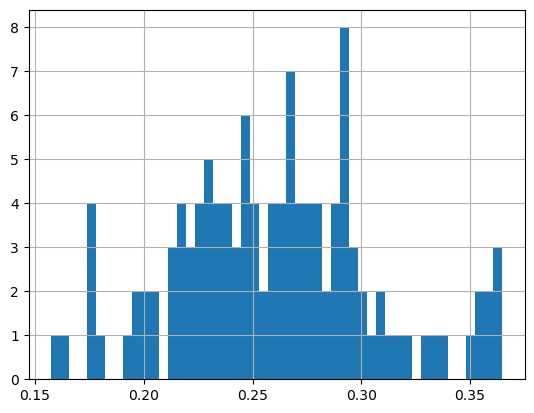

In [31]:
pd.DataFrame(gs_SV.cv_results_)['mean_test_score'].hist(bins=50);

## KNeighbors

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
grilla_KN = {
    "classifier": [KNeighborsClassifier()],
    "classifier__n_neighbors" :[3, 5, 10],
    "classifier__weights" : ['uniform', 'distance'],
    "selector__percentile": [25, 50, 75, 95, 100],
    "selector__score_func":[f_classif],
    "procesamiento" : [preprocessing, preprocessing_bert, preprocessing_bert_bow, preprocessing_bow],
    "procesamiento__BoC-cat__min_df" : [0.05],
    "procesamiento__BoC-genres__min_df" : [0.05],
    "procesamiento__BoC-tags__min_df" : [0.05],
    "procesamiento__BoC-dev__min_df" : [2],
    "procesamiento__BoC-pub__min_df" : [2],
}

gs_KN = HalvingGridSearchCV(
    pipeline,
    grilla_KN,
    scoring = 'f1_weighted',
    n_jobs=-1,
    verbose = 0,
    random_state = 0,
    error_score = 0
)

In [21]:
gs_KN.fit(X_train, y_train)

/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_select

HalvingGridSearchCV(error_score=0,
                    estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<__main__.CategoriesTokenizer object at 0x7fcf42735960>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<__main__.CategoriesTokenizer object at 0x7fcf42735960>),
                                                                                'categories'),
                                                                               ('BoC-g...
                                                                                   'short_description')])],
                                'procesamiento__BoC-cat__min_df': [0.05],
                                'procesamiento__BoC-dev__min_df': [2],
                                'procesamiento__BoC-genres__min_df': [0.05],
                                'procesamiento__BoC-pub__min_df': [2],
                                'procesamiento__BoC-tags__min_df': [0.05],
                                'selector__percentile': [25, 50, 75, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7fd0003472e0>]},
                    random_state=0, scoring='f1_weighted')

El mejor modelo encontrado es el siguiente

In [22]:
gs_KN.best_params_ 

{'classifier': KNeighborsClassifier(weights='distance'),
 'classifier__n_neighbors': 5,
 'classifier__weights': 'distance',
 'procesamiento': ColumnTransformer(transformers=[('BoC-plat',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.CategoriesTokenizer object at 0x7fcf42735960>),
                                  'platforms'),
                                 ('BoC-cat',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.CategoriesTokenizer object at 0x7fcf42735960>),
                                  'categories'),
                                 ('BoC-genres',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.CategoriesTokenizer obj...
                                                  tokenizer=<__main__.CategoriesTokenizer object at 0

y sus métricas son

In [23]:
gs_KN.best_score_

0.30028761040622065

In [24]:
from sklearn.metrics import classification_report

print("Resultados clasificación K-Neighbors")
gs_KN.fit(X_train, y_train)
y_pred = gs_KN.predict(X_eval)

Resultados clasificación K-Neighbors


/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/camilo/miniconda3/envs/prog_cientifica/lib/python3.10/site-packages/sklearn/feature_select

In [25]:
print(classification_report(y_eval,y_pred))

                 precision    recall  f1-score   support

          Mixed       0.27      0.23      0.25       497
Mostly Positive       0.24      0.25      0.25       512
       Negative       0.38      0.35      0.37       387
       Positive       0.28      0.36      0.32       610
  Very Positive       0.29      0.22      0.25       359

       accuracy                           0.29      2365
      macro avg       0.29      0.28      0.29      2365
   weighted avg       0.29      0.29      0.28      2365



Resultados generales del gridsearch:

In [26]:
pd.DataFrame(gs_KN.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_neighbors,param_classifier__weights,param_procesamiento,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,68,0.012705,0.009881,0.003003,0.006005,KNeighborsClassifier(weights='distance'),3,uniform,"ColumnTransformer(transformers=[('BoC-plat',\n...",...,0.017582,0.035165,163,0.603113,0.0,0.0,0.0,0.0,0.120623,0.241245
1,0,68,0.014124,0.013040,0.005328,0.010657,KNeighborsClassifier(weights='distance'),3,uniform,"ColumnTransformer(transformers=[('BoC-plat',\n...",...,0.017582,0.035165,163,0.514799,0.0,0.0,0.0,0.0,0.102960,0.205920
2,0,68,0.017442,0.015115,0.003630,0.007260,KNeighborsClassifier(weights='distance'),3,uniform,"ColumnTransformer(transformers=[('BoC-plat',\n...",...,0.044755,0.089510,104,0.551603,0.0,0.0,0.0,0.0,0.110321,0.220641
3,0,68,0.014757,0.010162,0.005031,0.010062,KNeighborsClassifier(weights='distance'),3,uniform,"ColumnTransformer(transformers=[('BoC-plat',\n...",...,0.027350,0.054701,138,0.612313,0.0,0.0,0.0,0.0,0.122463,0.244925
4,0,68,0.016272,0.012747,0.003918,0.007836,KNeighborsClassifier(weights='distance'),3,uniform,"ColumnTransformer(transformers=[('BoC-plat',\n...",...,0.036923,0.073846,114,0.595263,0.0,0.0,0.0,0.0,0.119053,0.238105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,3,1836,0.187295,0.023198,0.150685,0.021067,KNeighborsClassifier(weights='distance'),3,distance,"ColumnTransformer(transformers=[('BoC-plat',\n...",...,0.291895,0.030445,3,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000
177,3,1836,4.264238,0.262764,0.973698,0.224698,KNeighborsClassifier(weights='distance'),10,distance,"ColumnTransformer(transformers=[('BoC-plat',\n...",...,0.282072,0.022146,8,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000
178,3,1836,0.192170,0.004177,0.141838,0.003227,KNeighborsClassifier(weights='distance'),3,distance,"ColumnTransformer(transformers=[('BoC-plat',\n...",...,0.266477,0.034523,16,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000
179,4,5508,0.296849,0.039117,0.967626,0.028167,KNeighborsClassifier(weights='distance'),5,distance,"ColumnTransformer(transformers=[('BoC-plat',\n...",...,0.300288,0.008055,1,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000


In [27]:
pd.DataFrame(gs_KN.cv_results_)['mean_test_score'].max()

0.30028761040622065

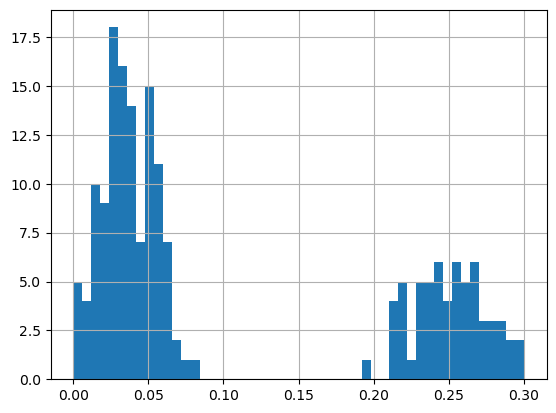

In [32]:
pd.DataFrame(gs_KN.cv_results_)['mean_test_score'].hist(bins=50);

# Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
grilla_RF = {
    "classifier": [RandomForestClassifier(random_state=0)],
    "classifier__n_estimators" :[25, 50, 100, 250, 500],
    "selector__percentile": [25, 50, 75, 95, 100],
    "selector__score_func":[f_classif],
    "procesamiento" : [preprocessing, preprocessing_bert, preprocessing_bert_bow, preprocessing_bow],
    "procesamiento__BoC-cat__min_df" : [0.05],
    "procesamiento__BoC-genres__min_df" : [0.05],
    "procesamiento__BoC-tags__min_df" : [0.05],
    "procesamiento__BoC-dev__min_df" : [2],
    "procesamiento__BoC-pub__min_df" : [2],
}

gs_RF = HalvingGridSearchCV(
    pipeline,
    grilla_RF,
    scoring = 'f1_weighted',
    n_jobs=-1,
    verbose = 0,
    random_state = 0,
    error_score = 0
)

In [ ]:
gs_RF.fit(X_train, y_train)

El mejor modelo encontrado es el siguiente

In [36]:
gs_RF.best_params_ 

{'classifier': RandomForestClassifier(n_estimators=250, random_state=0),
 'classifier__n_estimators': 250,
 'procesamiento': ColumnTransformer(transformers=[('BoC-plat',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.CategoriesTokenizer object at 0x7fcf42735960>),
                                  'platforms'),
                                 ('BoC-cat',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.CategoriesTokenizer object at 0x7fcf42735960>),
                                  'categories'),
                                 ('BoC-genres',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.CategoriesTokenizer obj...
                                                  tokenizer=<__main__.CategoriesTokenizer object at 0x7fcf427359c0>),


y sus métricas son

In [37]:
gs_RF.best_score_

0.36713418472919895

In [ ]:
from sklearn.metrics import classification_report

print("Resultados clasificación Random Forest")
gs_RF.fit(X_train, y_train)
y_pred = gs_RF.predict(X_eval)

In [39]:
print(classification_report(y_eval,y_pred))

                 precision    recall  f1-score   support

          Mixed       0.32      0.31      0.31       497
Mostly Positive       0.23      0.17      0.20       512
       Negative       0.43      0.37      0.39       387
       Positive       0.32      0.52      0.40       610
  Very Positive       0.43      0.26      0.32       359

       accuracy                           0.33      2365
      macro avg       0.35      0.32      0.32      2365
   weighted avg       0.34      0.33      0.32      2365



Resultados generales del gridsearch:

In [40]:
pd.DataFrame(gs_RF.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_estimators,param_procesamiento,param_procesamiento__BoC-cat__min_df,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,68,0.017761,0.020879,0.002985,0.005970,"RandomForestClassifier(n_estimators=250, rando...",25,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.036044,0.072088,141,0.904550,0.0,0.0,0.0,0.0,0.180910,0.361820
1,0,68,0.017852,0.021230,0.003095,0.006190,"RandomForestClassifier(n_estimators=250, rando...",25,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.085470,0.170940,57,0.979894,0.0,0.0,0.0,0.0,0.195979,0.391958
2,0,68,0.026071,0.035560,0.005041,0.010081,"RandomForestClassifier(n_estimators=250, rando...",25,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.020513,0.041026,148,0.981305,0.0,0.0,0.0,0.0,0.196261,0.392522
3,0,68,0.028084,0.037931,0.004791,0.009583,"RandomForestClassifier(n_estimators=250, rando...",25,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.023077,0.046154,147,1.000000,0.0,0.0,0.0,0.0,0.200000,0.400000
4,0,68,0.022404,0.026376,0.003647,0.007294,"RandomForestClassifier(n_estimators=250, rando...",25,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.047692,0.095385,107,1.000000,0.0,0.0,0.0,0.0,0.200000,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,3,1836,4.896561,0.232949,0.172823,0.017898,"RandomForestClassifier(n_estimators=250, rando...",250,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.361923,0.021706,3,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000
148,3,1836,2.043851,0.197567,0.106276,0.014154,"RandomForestClassifier(n_estimators=250, rando...",100,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.344489,0.035002,6,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000
149,3,1836,5.462502,0.122336,0.151965,0.004631,"RandomForestClassifier(n_estimators=250, rando...",500,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.350993,0.014295,5,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000
150,4,5508,16.777233,0.471365,0.283107,0.037932,"RandomForestClassifier(n_estimators=250, rando...",250,"ColumnTransformer(transformers=[('BoC-plat',\n...",0.05,...,0.367113,0.011525,2,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000


In [41]:
pd.DataFrame(gs_RF.cv_results_)['mean_test_score'].max()

0.36713418472919895

<AxesSubplot:>

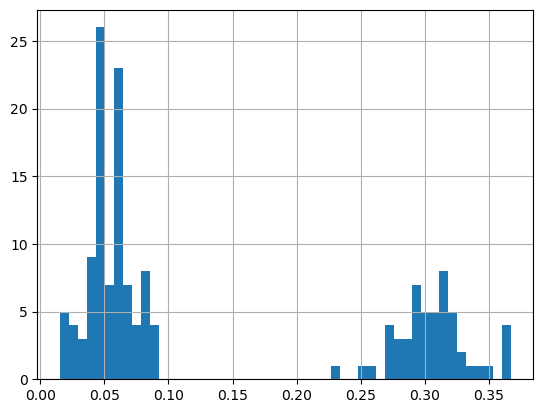

In [42]:
pd.DataFrame(gs_RF.cv_results_)['mean_test_score'].hist(bins=50)

# Multi layer perceptron

In [11]:
from sklearn.neural_network import MLPClassifier

In [14]:
grilla_MLP = {
    "classifier": [MLPClassifier()],
    "classifier__hidden_layer_sizes":[(100,),(200,),(100,50,),(200,100,)],
    "classifier__solver" : ['sgd', 'adam'],
    "classifier__learning_rate" : ['constant', 'invscaling', 'adaptive'],
    "procesamiento" : [preprocessing, preprocessing_bert],
    "classifier__learning_rate_init" : [0.1,0.01,0.001,0.0001],
    "selector__percentile": [90, 95, 100],
    "selector__score_func":[f_classif],
    "procesamiento__BoC-cat__min_df" : [0.05],
    "procesamiento__BoC-genres__min_df" : [0.05],
    "procesamiento__BoC-tags__min_df" : [0.05],
    "procesamiento__BoC-dev__min_df" : [0],
    "procesamiento__BoC-pub__min_df" : [0],
}

gs_MLP = HalvingGridSearchCV(
    pipeline,
    grilla_MLP,
    scoring = 'f1_weighted',
    n_jobs=-1,
    verbose = 0,
    random_state = 0,
    error_score = 0
)

In [15]:
gs_MLP.fit(X_train, y_train)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/agonzalez/miniconda3/envs/mds7202/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/agonzalez/miniconda3/envs/mds7202/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/agonzalez/miniconda3/envs/mds7202/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/agonzalez/miniconda3/envs/mds7202/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/agonzalez/miniconda3/envs/mds7202/lib/python3.10/site-packages/sklearn/feature_selection/_univariate

HalvingGridSearchCV(error_score=0,
                    estimator=Pipeline(steps=[('procesamiento',
                                               ColumnTransformer(transformers=[('BoC-plat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<__main__.CategoriesTokenizer object at 0x7f55a9453eb0>),
                                                                                'platforms'),
                                                                               ('BoC-cat',
                                                                                CountVectorizer(min_df=0.05,
                                                                                                tokenizer=<__main__.CategoriesTokenizer object at 0x7f55a9453eb0>),
                                                                                'categories'),
                                                                               ('BoC-g...
                                                                                    'bert4',
                                                                                    'bert5'])])],
                                'procesamiento__BoC-cat__min_df': [0.05],
                                'procesamiento__BoC-dev__min_df': [0],
                                'procesamiento__BoC-genres__min_df': [0.05],
                                'procesamiento__BoC-pub__min_df': [0],
                                'procesamiento__BoC-tags__min_df': [0.05],
                                'selector__percentile': [90, 95, 100],
                                'selector__score_func': [<function f_classif at 0x7f55c9ac0670>]},
                    random_state=0, scoring='f1_weighted')

El mejor modelo encontrado es el siguiente

In [16]:
gs_MLP.best_params_ 

{'classifier': MLPClassifier(hidden_layer_sizes=(200,), learning_rate_init=0.01, solver='sgd'),
 'classifier__hidden_layer_sizes': (200,),
 'classifier__learning_rate': 'constant',
 'classifier__learning_rate_init': 0.01,
 'classifier__solver': 'sgd',
 'procesamiento': ColumnTransformer(transformers=[('BoC-plat',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.CategoriesTokenizer object at 0x7f55bb42f910>),
                                  'platforms'),
                                 ('BoC-cat',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.CategoriesTokenizer object at 0x7f55bb42f910>),
                                  'categories'),
                                 ('BoC-genres',
                                  CountVectorizer(min_df=0.05,
                                                  tokenizer=<__main__.

y sus métricas son

In [17]:
gs_MLP.best_score_

0.3628511646708167

In [21]:
from sklearn.metrics import classification_report

print("Resultados clasificación MLP")
# gs_MLP.fit(X_train, y_train)
y_pred = gs_MLP.predict(X_eval)
print(classification_report(y_eval,y_pred))

Resultados clasificación MLP
                 precision    recall  f1-score   support

          Mixed       0.31      0.28      0.30       497
Mostly Positive       0.25      0.22      0.24       512
       Negative       0.44      0.41      0.43       387
       Positive       0.34      0.40      0.37       610
  Very Positive       0.36      0.38      0.37       359

       accuracy                           0.34      2365
      macro avg       0.34      0.34      0.34      2365
   weighted avg       0.33      0.34      0.33      2365



Resultados generales del gridsearch:

In [22]:
pd.DataFrame(gs_MLP.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__hidden_layer_sizes,param_classifier__learning_rate,param_classifier__learning_rate_init,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,50,0.294270,0.052166,0.025261,0.007604,"MLPClassifier(hidden_layer_sizes=(200,), learn...","(100,)",constant,0.1,...,0.274321,0.168753,279,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0,50,0.217853,0.057709,0.020999,0.002183,"MLPClassifier(hidden_layer_sizes=(200,), learn...","(100,)",constant,0.1,...,0.282011,0.160280,235,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0,50,0.204213,0.059219,0.027845,0.004507,"MLPClassifier(hidden_layer_sizes=(200,), learn...","(100,)",constant,0.1,...,0.245150,0.131664,466,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0,50,0.143042,0.031951,0.025231,0.004855,"MLPClassifier(hidden_layer_sizes=(200,), learn...","(100,)",constant,0.1,...,0.225608,0.076359,580,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0,50,0.121455,0.035297,0.016881,0.005338,"MLPClassifier(hidden_layer_sizes=(200,), learn...","(100,)",constant,0.1,...,0.237460,0.056141,519,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,4,4050,397.660842,7.532576,0.271549,0.018626,"MLPClassifier(hidden_layer_sizes=(200,), learn...","(100, 50)",constant,0.01,...,0.345004,0.010404,18,0.998765,0.999074,0.997226,0.997840,0.998765,0.998334,0.000692
858,4,4050,380.787505,8.725792,0.321810,0.036326,"MLPClassifier(hidden_layer_sizes=(200,), learn...","(100,)",adaptive,0.01,...,0.361778,0.010144,7,0.958623,0.960497,0.949981,0.951920,0.960152,0.956234,0.004403
859,4,4050,598.918810,32.056089,0.112332,0.088908,"MLPClassifier(hidden_layer_sizes=(200,), learn...","(200,)",adaptive,0.01,...,0.361458,0.008248,8,0.970105,0.966640,0.961415,0.962698,0.968563,0.965884,0.003337
860,4,4050,546.295022,25.215610,0.069920,0.071188,"MLPClassifier(hidden_layer_sizes=(200,), learn...","(200,)",constant,0.01,...,0.362851,0.006647,6,0.967281,0.964201,0.964188,0.958922,0.966341,0.964187,0.002896


In [23]:
pd.DataFrame(gs_MLP.cv_results_)['mean_test_score'].max()

0.3734539534539535

**Resumen**

| Modelo | **f1 CV GridSearch** |
|:---:|:---:|
| **Lineal SV** (baseline) | **0.36** |
| **KNeighborsRegressor** | **0.30** |
| **RandomForestRegressor** | **0.36** |
| **MLPRegressor** | **0.36** |
| **VotingRegressor** | - |